<a href="https://colab.research.google.com/github/NigarSultana156/499A/blob/main/BertModelSentimentAnalysis(20kData).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Required Libraries

In [ ]:
!pip install transformers torch torch-optimizer imbalanced-learn scikit-learn matplotlib --quiet


# 2. Load and Preprocess The Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your scraped data from the provided URL
url = "https://raw.githubusercontent.com/amanullahshah32/Review-Scraping/refs/heads/main/Dataset/cleaned_dataset.csv"
df = pd.read_csv(url)

# Drop rows where 'review_description' or 'rating' are missing
df.dropna(subset=['review_description', 'rating'], inplace=True)

# Sample 2,000 rows randomly
df = df.sample(n=20000, random_state=42)

# Shuffle the sampled dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a sentiment column based on rating (1-2 -> Negative, 3 -> Neutral, 4-5 -> Positive)
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['review_description'], df['sentiment'], test_size=0.2, random_state=42)

# Convert labels to list
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

# Display the first few rows of the shuffled dataset
print(df.head())


        source                             review_id      user_name  \
0  Google Play  950646a1-c3af-491d-8293-f05be2150a48  A Google user   
1  Google Play  f28aa7ef-407e-41a5-bf99-a36a429bc091  A Google user   
2  Google Play  d829efbd-3415-4a11-b3a4-8a5eee3fd2d0  A Google user   
3  Google Play  0bfab82e-752a-4e53-9678-65d30b326b76  A Google user   
4  Google Play  840988cd-d51d-4630-b133-8b8ed40a3d7c  A Google user   

   review_title                                 review_description  rating  \
0           NaN  Seems to have just about every drug covered wi...       5   
1           NaN         Interesting, informative, and educational.       5   
2           NaN                         it's has very useful value       5   
3           NaN  I REALLY like it, I find it so much easier to ...       4   
4           NaN  Looks really good. Easy to use once you read t...       5   

   thumbs_up          review_date developer_response developer_response_date  \
0          1  2019-03-18

#3.Handle Class Imbalance

In [ ]:
from imblearn.over_sampling import RandomOverSampler



# Initialize RandomOverSampler

ros = RandomOverSampler(random_state=42)



# Since train_texts is a pandas Series, we need to reshape it to a DataFrame

train_texts_df = pd.DataFrame(train_texts)



# Apply oversampling to balance the classes

train_texts_resampled, train_labels_resampled = ros.fit_resample(train_texts_df, train_labels)



# Convert the DataFrame of resampled texts back to a list

train_texts_resampled = train_texts_resampled.squeeze().tolist()  # .squeeze() ensures a flat list


#4. Tokenization with BERT

In [ ]:
from transformers import BertTokenizer



# Load the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



# Tokenize the text data

train_encodings = tokenizer(train_texts_resampled, truncation=True, padding=True, max_length=128)

val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#5. Create a Dataset Class for PyTorch

In [ ]:
import torch

from torch.utils.data import Dataset



class ReviewDataset(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings

        self.labels = labels



    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        item['labels'] = torch.tensor(self.labels[idx])

        return item



    def __len__(self):

        return len(self.labels)



# Create the PyTorch datasets

train_dataset = ReviewDataset(train_encodings, train_labels_resampled)

val_dataset = ReviewDataset(val_encodings, val_labels)


#6. Load Pre-trained BERT Model

In [ ]:
import torch

from transformers import BertForSequenceClassification



# Define the device (use GPU if available)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Load the pre-trained BERT model for sequence classification (3 classes)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)



# Move the model to the appropriate device

model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#7. Set Up DataLoader, Optimizer, and Scheduler

In [ ]:
from torch.utils.data import DataLoader

from transformers import AdamW, get_linear_schedule_with_warmup



# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)



# Optimizer: AdamW with weight decay and a smaller learning rate

learning_rate = 3e-5

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)



# Scheduler for learning rate decay

epochs = 5

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#8. Class Weights for Imbalance

In [ ]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



# Define the device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



# Convert the class labels to a NumPy array

classes = np.array([0, 1, 2])



# Calculate class weights

class_weights = compute_class_weight('balanced', classes=classes, y=train_labels_resampled)



# Convert to a PyTorch tensor and move it to the appropriate device

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



# Use the weights in the loss function

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


#9. Training Loop

Epoch 1 completed in 458.63 seconds
Training Accuracy: 0.8675
Validation Accuracy: 0.8805
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.68      0.79      0.73       433
           1       0.12      0.20      0.15       143
           2       0.97      0.92      0.94      3424

    accuracy                           0.88      4000
   macro avg       0.59      0.64      0.61      4000
weighted avg       0.90      0.88      0.89      4000

Epoch 2 completed in 459.01 seconds
Training Accuracy: 0.9596
Validation Accuracy: 0.8915
Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.70      0.75      0.73       433
           1       0.13      0.14      0.14       143
           2       0.95      0.94      0.95      3424

    accuracy                           0.89      4000
   macro avg       0.59      0.61      0.60      4000
weighted avg       0.90      0.89      

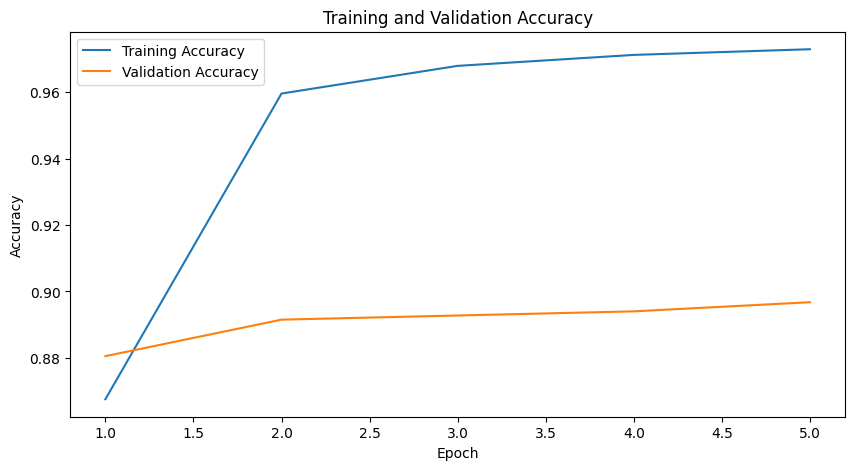

In [ ]:
import time

import torch

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt



# Initialize lists to track metrics

train_accuracies = []

val_accuracies = []

epoch_durations = []



# Loop for training and validation

for epoch in range(5):  # Training for 10 epochs

    start_time = time.time()  # Start time for the epoch



    # Training loop

    model.train()

    train_preds = []

    train_labels_epoch = []  # Track labels for each epoch

    for batch in train_loader:

        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        scheduler.step()

        optimizer.zero_grad()



        # Collect predictions

        train_preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

        train_labels_epoch.extend(batch['labels'].cpu().numpy())



    end_time = time.time()  # End time for the epoch

    epoch_duration = end_time - start_time  # Time taken for the epoch

    epoch_durations.append(epoch_duration)



    # Calculate training accuracy

    train_acc = accuracy_score(train_labels_epoch, train_preds)

    train_accuracies.append(train_acc)



    # Validation loop

    model.eval()

    val_preds = []

    with torch.no_grad():

        for batch in val_loader:

            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)

            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)

            val_preds.extend(predictions.cpu().numpy())



    # Calculate validation accuracy

    val_acc = accuracy_score(val_labels, val_preds)

    val_accuracies.append(val_acc)



    print(f'Epoch {epoch+1} completed in {epoch_duration:.2f} seconds')

    print(f'Training Accuracy: {train_acc:.4f}')

    print(f'Validation Accuracy: {val_acc:.4f}')



    # Classification report

    print(f'Classification Report (Validation):\n {classification_report(val_labels, val_preds)}')



epochs = 5



# Visualize the results

plt.figure(figsize=(10, 5))

plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')

plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()

#10. Make New Predictions

In [ ]:
# Make predictions on new data (Example: a list of review texts)

new_reviews = [

    "The app is very helpful for tracking my health.",

    "I had a bad experience, it kept crashing.",

    "Great app, I would definitely recommend it to others!"

]



# Tokenize the new reviews

new_encodings = tokenizer(new_reviews, truncation=True, padding=True, max_length=128, return_tensors='pt')



# Move the tensors to the appropriate device

new_encodings = {key: val.to(device) for key, val in new_encodings.items()}



# Perform the prediction

model.eval()

with torch.no_grad():

    outputs = model(**new_encodings)

    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()



# Print the predictions (0 = Negative, 1 = Neutral, 2 = Positive)

for review, pred in zip(new_reviews, predictions):

    sentiment = ['Negative', 'Neutral', 'Positive'][pred]

    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: The app is very helpful for tracking my health.
Predicted Sentiment: Positive

Review: I had a bad experience, it kept crashing.
Predicted Sentiment: Negative

Review: Great app, I would definitely recommend it to others!
Predicted Sentiment: Positive



In [ ]:
!pip install shap


#11. SHAP for Model Explanation

In [ ]:
import shap

import torch

from transformers import BertTokenizer



# Ensure the model is in evaluation mode and on the correct device (GPU if available)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)



# Define a function for tokenizing text

def tokenize_text(texts, tokenizer, max_length=128):

    return tokenizer(

        list(texts),  # Ensure texts are in the correct format

        truncation=True,

        padding='max_length',

        max_length=max_length,

        return_tensors="pt"

    )



# Tokenizer instance

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



# A wrapper function for SHAP to pass through the model

def predict(texts):

    inputs = tokenize_text(texts, tokenizer)

    inputs = {key: val.to(device) for key, val in inputs.items()}  # Ensure inputs are on the same device as the model

    with torch.no_grad():

        outputs = model(**inputs)

        return torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()



# SHAP Explainer setup

explainer = shap.Explainer(predict, tokenizer)



# Select a few samples from your validation set to explain

texts_to_explain = [str(text) for text in val_texts[:5]]  # Explicitly ensure a list of strings

shap_values = explainer(texts_to_explain)



# Visualize the explanations

for i, text in enumerate(texts_to_explain):

    print(f"\n--- Explanation for Text {i+1}: ---")

    print(text)

    shap.text_plot(shap_values[i])




--- Explanation for Text 1: ---
Very accurate predictions 👏



--- Explanation for Text 2: ---
good for learning



--- Explanation for Text 3: ---
3rd class app



--- Explanation for Text 4: ---
Nice App.. Very useful



--- Explanation for Text 5: ---
very useful and handy


#12. Exploratory Data Analysis (EDA)

In [ ]:
# Basic overview of the dataset

print(df.info())  # Column types and non-null counts

print(df.describe())  # Summary statistics for numerical columns

print(df.head())  # Preview the first few rows

print(df['sentiment'].value_counts())  # Distribution of sentiments


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20000 non-null  object 
 1   review_id                20000 non-null  object 
 2   user_name                20000 non-null  object 
 3   review_title             0 non-null      float64
 4   review_description       20000 non-null  object 
 5   rating                   20000 non-null  int64  
 6   thumbs_up                20000 non-null  int64  
 7   review_date              20000 non-null  object 
 8   developer_response       3153 non-null   object 
 9   developer_response_date  3153 non-null   object 
 10  appVersion               17187 non-null  object 
 11  language_code            20000 non-null  object 
 12  country_code             20000 non-null  object 
 13  app_name                 20000 non-null  object 
 14  sentiment             

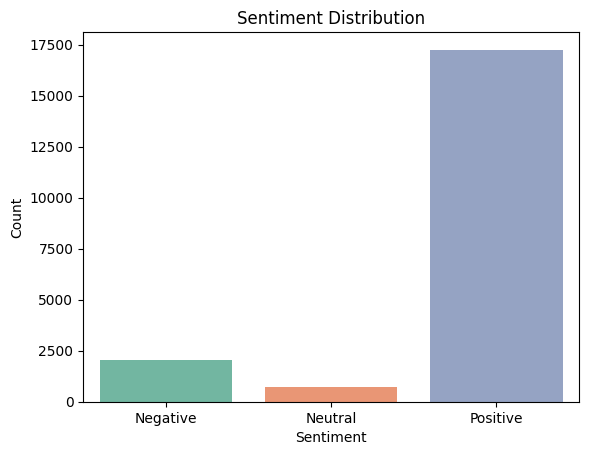

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns



# Plot the sentiment distribution

sns.countplot(data=df, x='sentiment', palette='Set2')

plt.title('Sentiment Distribution')

plt.xlabel('Sentiment')

plt.ylabel('Count')

plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

plt.show()


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


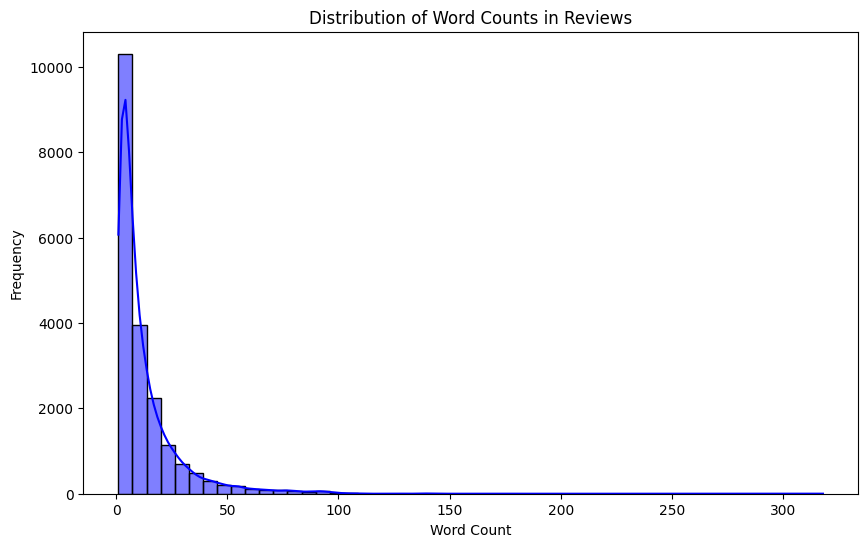

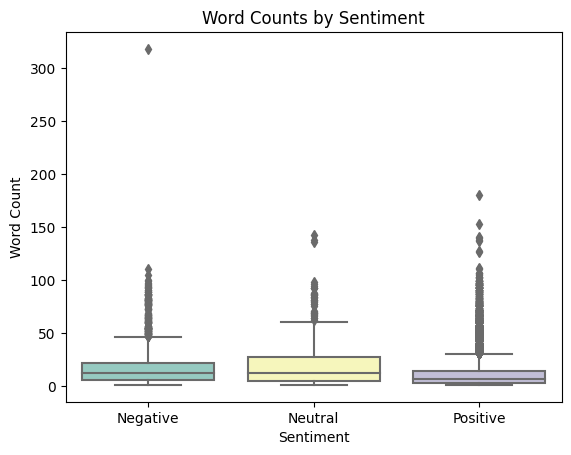

In [ ]:
# Add a column for word counts

df['word_count'] = df['review_description'].apply(lambda x: len(str(x).split()))



# Plot word count distribution

plt.figure(figsize=(10, 6))

sns.histplot(df['word_count'], bins=50, kde=True, color='blue')

plt.title('Distribution of Word Counts in Reviews')

plt.xlabel('Word Count')

plt.ylabel('Frequency')

plt.show()



# Compare word counts across sentiments

sns.boxplot(data=df, x='sentiment', y='word_count', palette='Set3')

plt.title('Word Counts by Sentiment')

plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

plt.xlabel('Sentiment')

plt.ylabel('Word Count')

plt.show()


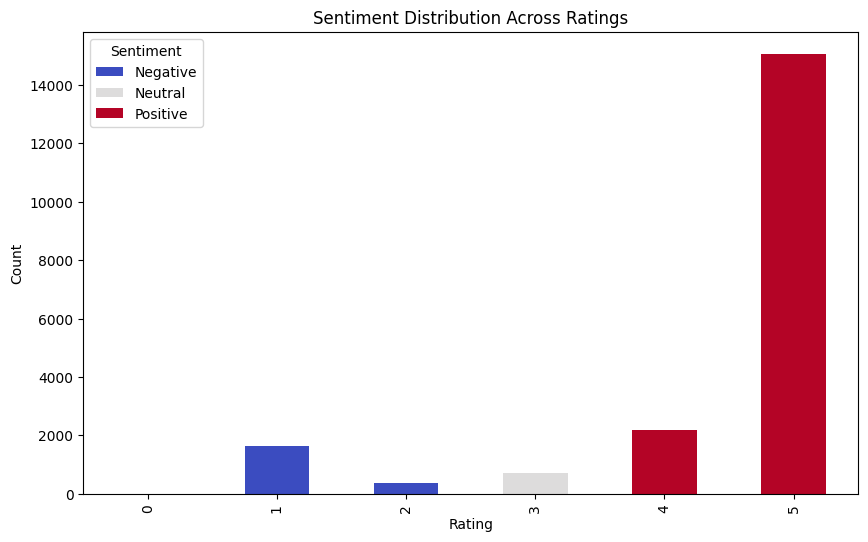

In [ ]:
# Sentiment distribution for each rating

rating_sentiment = df.groupby('rating')['sentiment'].value_counts().unstack()

rating_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='coolwarm')

plt.title('Sentiment Distribution Across Ratings')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])

plt.show()


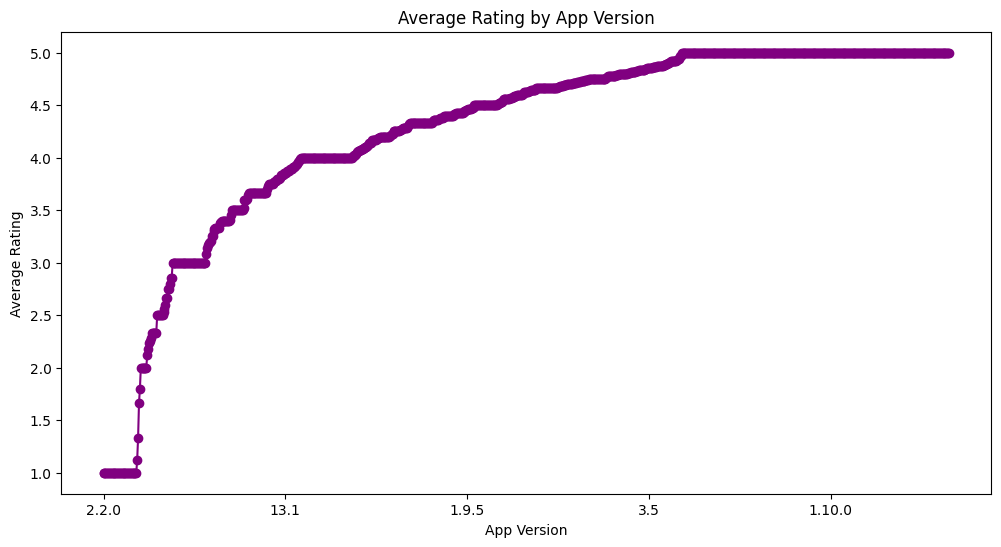

In [ ]:
# Average rating by app version

version_rating = df.groupby('appVersion')['rating'].mean().sort_values()



plt.figure(figsize=(12, 6))

version_rating.plot(kind='line', marker='o', color='purple')

plt.title('Average Rating by App Version')

plt.xlabel('App Version')

plt.ylabel('Average Rating')

plt.show()


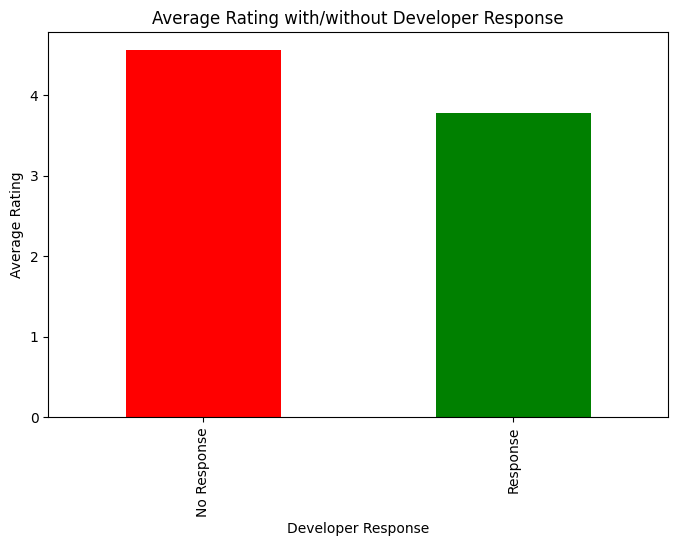

In [ ]:
# Create a column indicating whether a developer responded

df['has_dev_response'] = df['developer_response'].notnull()



# Compare average rating for apps with and without developer responses

response_rating = df.groupby('has_dev_response')['rating'].mean()



plt.figure(figsize=(8, 5))

response_rating.plot(kind='bar', color=['red', 'green'])

plt.title('Average Rating with/without Developer Response')

plt.xlabel('Developer Response')

plt.ylabel('Average Rating')

plt.xticks(ticks=[0, 1], labels=['No Response', 'Response'])

plt.show()


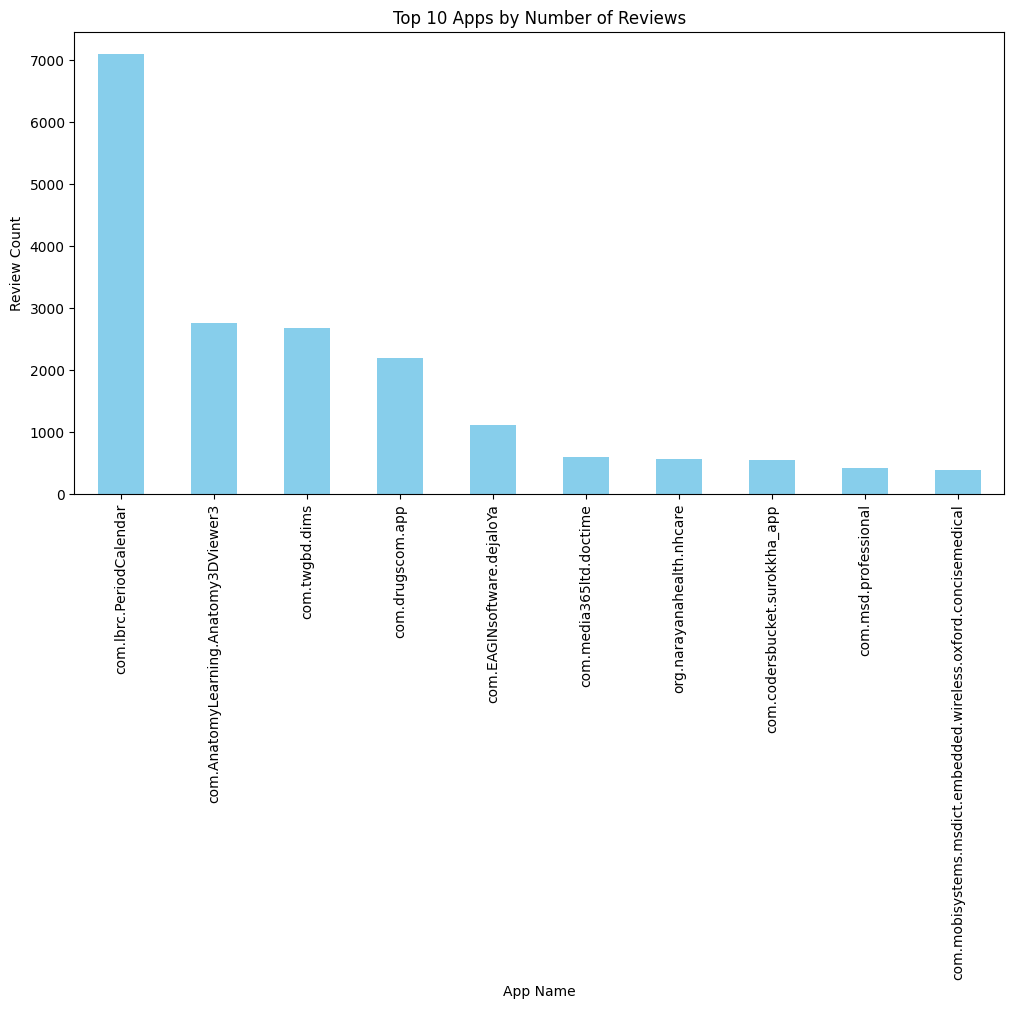

In [ ]:
# Top 10 apps by review count

top_apps = df['app_name'].value_counts().head(10)



plt.figure(figsize=(12, 6))

top_apps.plot(kind='bar', color='skyblue')

plt.title('Top 10 Apps by Number of Reviews')

plt.xlabel('App Name')

plt.ylabel('Review Count')

plt.show()


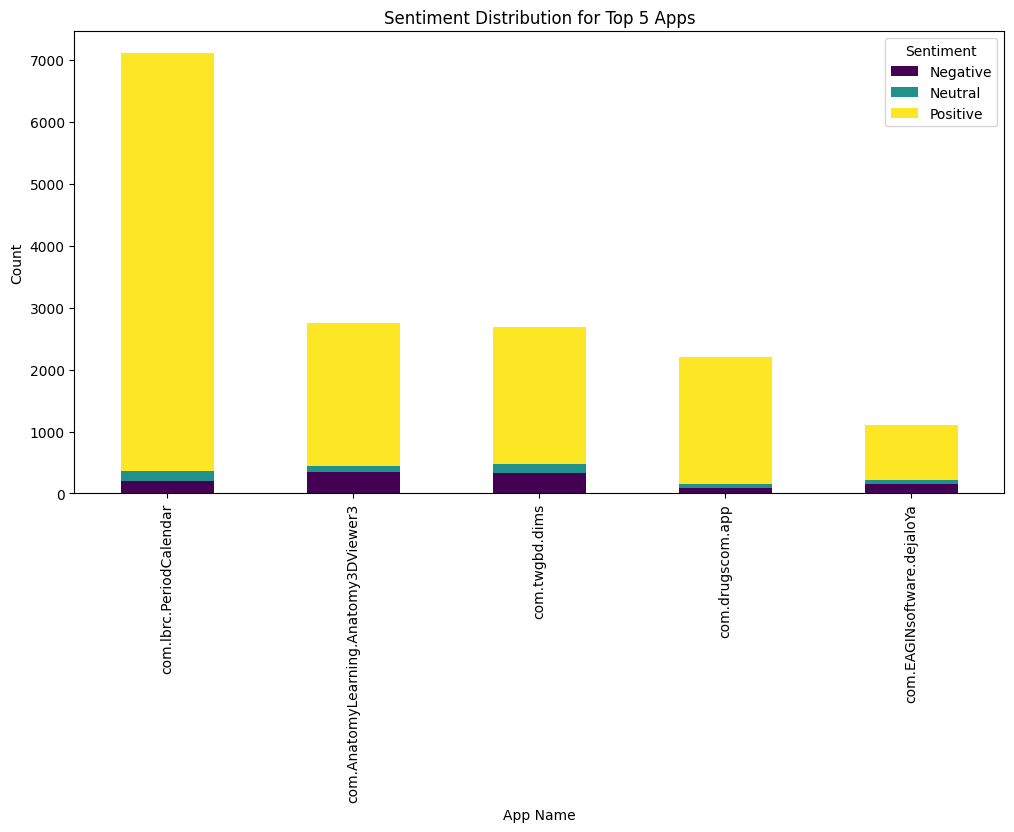

In [ ]:
# Sentiment distribution per app

sentiment_per_app = df.groupby('app_name')['sentiment'].value_counts().unstack()



# Plot for the top 5 apps by review count

top_5_apps = df['app_name'].value_counts().head(5).index

sentiment_per_app.loc[top_5_apps].plot(kind='bar', stacked=True, figsize=(12, 6), cmap='viridis')

plt.title('Sentiment Distribution for Top 5 Apps')

plt.xlabel('App Name')

plt.ylabel('Count')

plt.legend(title='Sentiment', labels=['Negative', 'Neutral', 'Positive'])

plt.show()


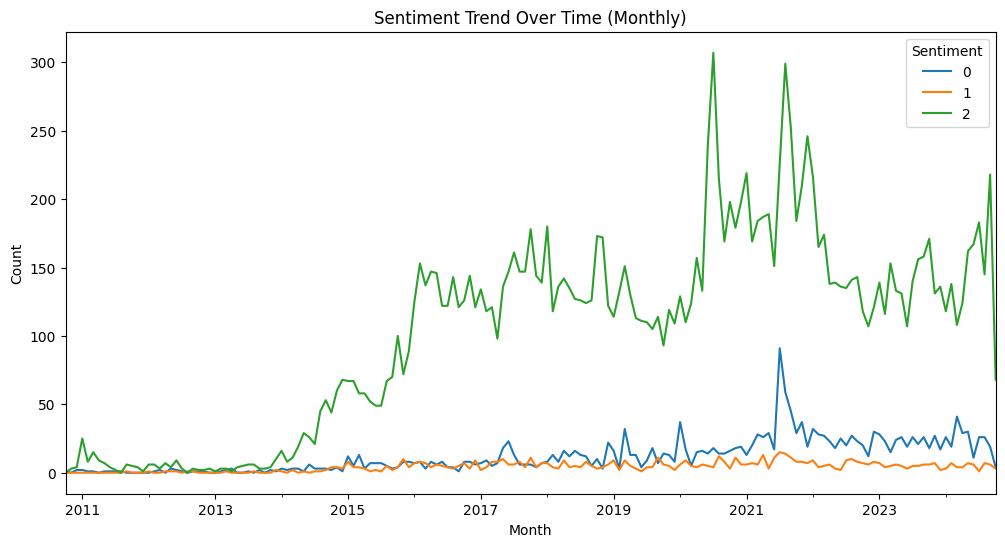

In [ ]:
 #Monthly Sentiment Trend

df['review_date'] = pd.to_datetime(df['review_date'])

df['month'] = df['review_date'].dt.to_period('M')

monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

monthly_sentiment.plot(kind='line', figsize=(12, 6))

plt.title('Sentiment Trend Over Time (Monthly)')

plt.xlabel('Month')

plt.ylabel('Count')

plt.legend(title='Sentiment')

plt.show()


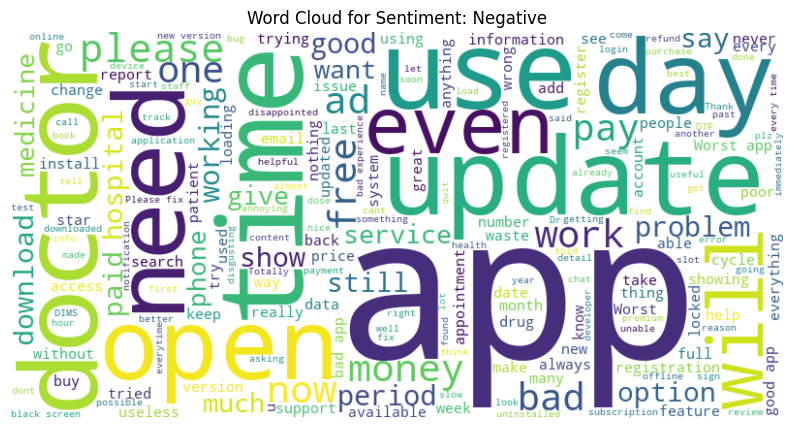

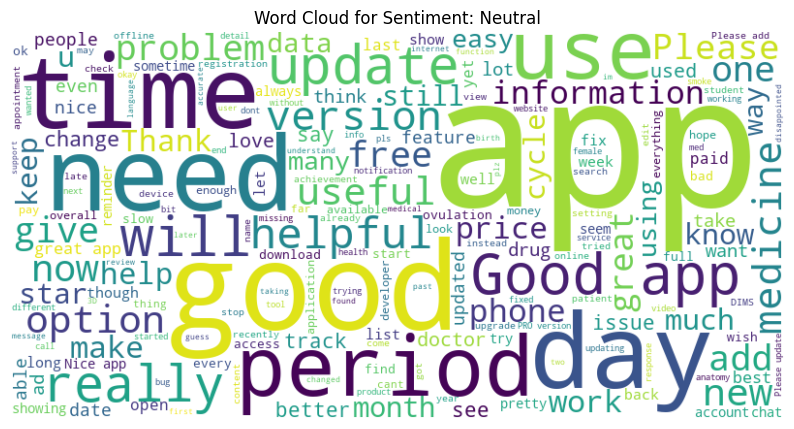

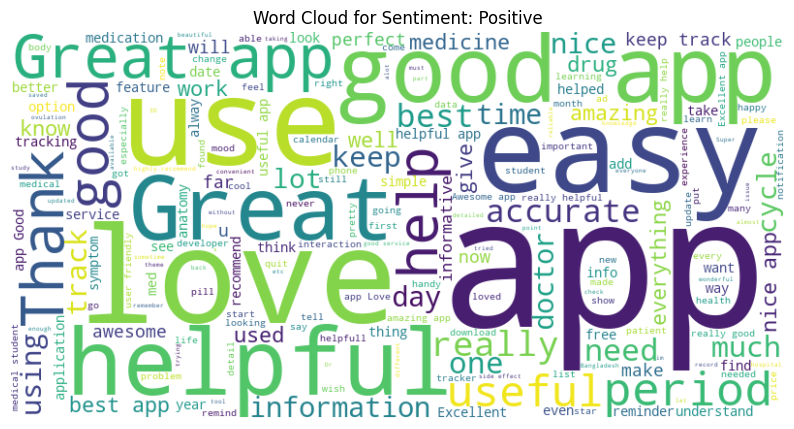

In [ ]:
from wordcloud import WordCloud



# Generate word clouds for each sentiment

for sentiment in [0, 1, 2]:

    text = " ".join(df[df['sentiment'] == sentiment]['review_description'])

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)



    plt.figure(figsize=(10, 6))

    plt.imshow(wordcloud, interpolation='bilinear')

    plt.axis('off')

    plt.title(f'Word Cloud for Sentiment: {"Negative" if sentiment == 0 else "Neutral" if sentiment == 1 else "Positive"}')

    plt.show()


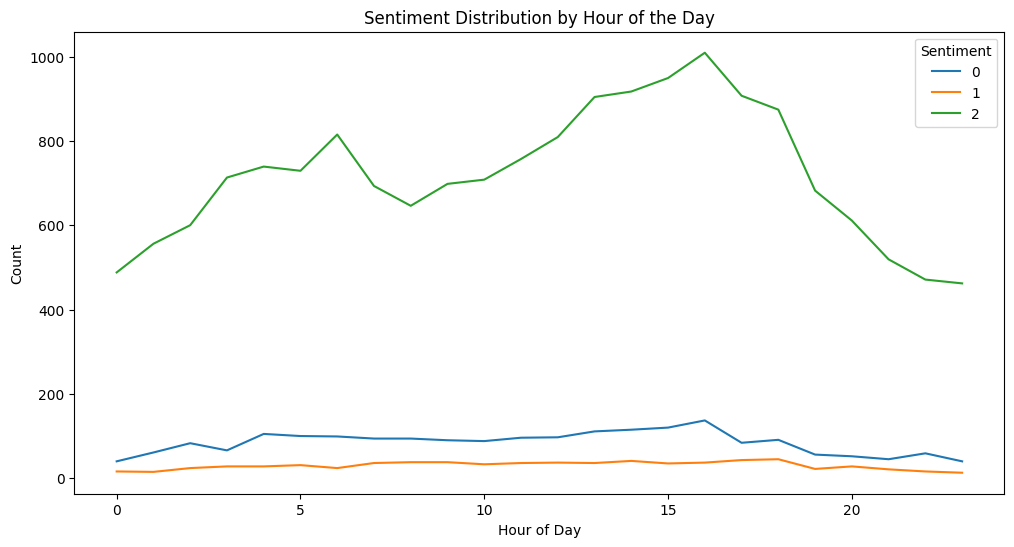

In [ ]:
#Review Time and Sentiment:

df['hour'] = df['review_date'].dt.hour

sentiment_by_hour = df.groupby('hour')['sentiment'].value_counts().unstack().fillna(0)

sentiment_by_hour.plot(kind='line', figsize=(12, 6))

plt.title('Sentiment Distribution by Hour of the Day')

plt.xlabel('Hour of Day')

plt.ylabel('Count')

plt.legend(title='Sentiment')

plt.show()


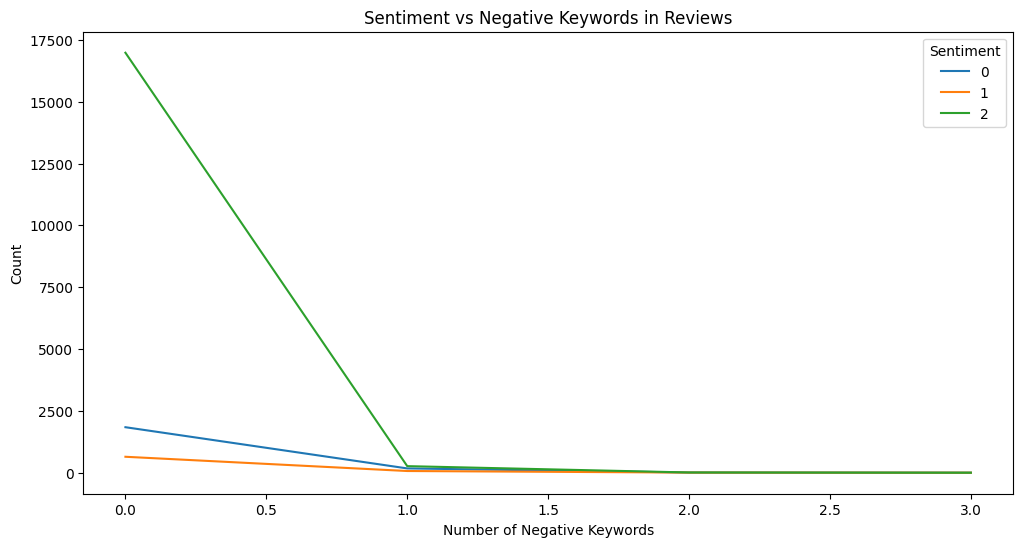

In [ ]:
#Sentiment Distribution by Review Content (Negative Keywords):

negative_keywords = ['bug', 'crash', 'slow', 'problem', 'issue']

df['negative_keywords_count'] = df['review_description'].apply(lambda x: sum(1 for word in negative_keywords if word in str(x).lower()))

sentiment_by_keywords = df.groupby('negative_keywords_count')['sentiment'].value_counts().unstack().fillna(0)

sentiment_by_keywords.plot(kind='line', figsize=(12, 6))

plt.title('Sentiment vs Negative Keywords in Reviews')

plt.xlabel('Number of Negative Keywords')

plt.ylabel('Count')

plt.legend(title='Sentiment')

plt.show()


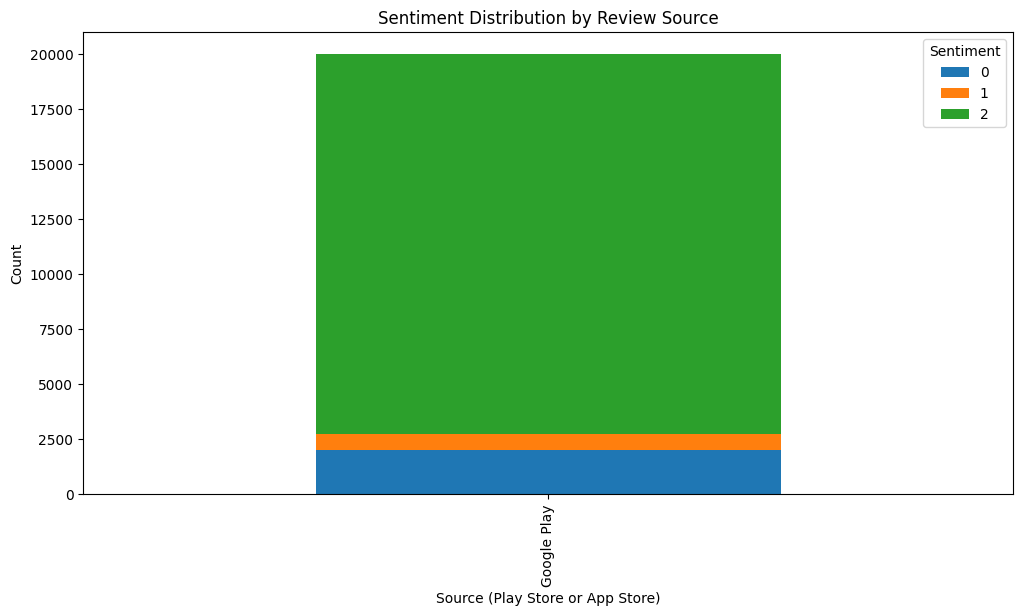

In [ ]:
#Sentiment Distribution Based on Review Source:

sentiment_by_source = df.groupby('source')['sentiment'].value_counts().unstack().fillna(0)

sentiment_by_source.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Sentiment Distribution by Review Source')

plt.xlabel('Source (Play Store or App Store)')

plt.ylabel('Count')

plt.legend(title='Sentiment')

plt.show()


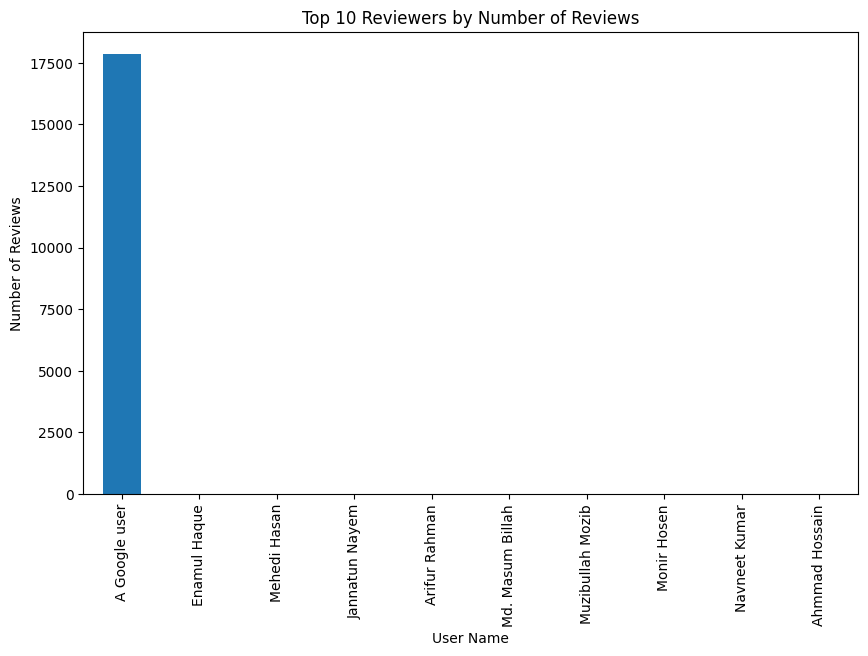

In [ ]:
#Top Reviewers:

top_reviewers = df['user_name'].value_counts().head(10)

top_reviewers.plot(kind='bar', figsize=(10, 6))

plt.title('Top 10 Reviewers by Number of Reviews')

plt.xlabel('User Name')

plt.ylabel('Number of Reviews')

plt.show()


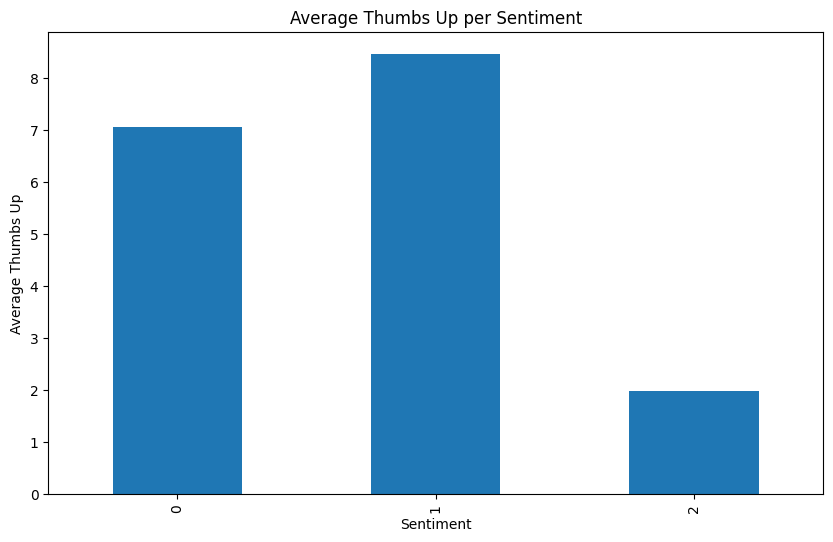

In [ ]:
#Sentiment Distribution vs Thumbs Up

df['thumbs_up'].groupby(df['sentiment']).mean().plot(kind='bar', figsize=(10, 6))

plt.title('Average Thumbs Up per Sentiment')

plt.xlabel('Sentiment')

plt.ylabel('Average Thumbs Up')

plt.show()


#13. Save and Load the Model

In [ ]:
import os



# Define the save directory

save_directory = "./saved_bert_model"



# Create the directory if it doesn't exist

os.makedirs(save_directory, exist_ok=True)



# Save the model and tokenizer

model.save_pretrained(save_directory)

tokenizer.save_pretrained(save_directory)



print(f"Model and tokenizer saved to {save_directory}")


Model and tokenizer saved to ./saved_bert_model


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification



# Load the model and tokenizer

loaded_model = BertForSequenceClassification.from_pretrained(save_directory)

loaded_tokenizer = BertTokenizer.from_pretrained(save_directory)



print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


#14. Bleu Score (not a ideal metric for sentiment analysis)

In [ ]:
pip install nltk


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from nltk.translate.bleu_score import sentence_bleu

from transformers import BertTokenizer, BertForSequenceClassification

import torch



# Example of your sentiment analysis model setup (BERT model)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')



# Define a function for tokenizing text

def tokenize_text(texts, tokenizer, max_length=128):

    return tokenizer(

        list(texts),  # Ensure texts are in the correct format

        truncation=True,

        padding='max_length',

        max_length=max_length,

        return_tensors="pt"

    )



# Your sentiment analysis prediction function

def predict(texts):

    inputs = tokenize_text(texts, tokenizer)

    with torch.no_grad():

        outputs = model(**inputs)

        # Assuming a simple classification problem with two classes (positive/negative)

        preds = torch.argmax(outputs.logits, dim=-1)

        return preds.cpu().numpy()



# Function to calculate BLEU score (for text generation)

def calculate_bleu(reference_texts, generated_texts):

    reference = [text.split() for text in reference_texts]

    hypothesis = [text.split() for text in generated_texts]



    bleu_scores = []

    for ref, hyp in zip(reference, hypothesis):

        bleu_score = sentence_bleu([ref], hyp)  # For 1-gram BLEU score

        bleu_scores.append(bleu_score)



    return bleu_scores



# Example input (sentiment labels)

texts = ["This is a great product!", "This is a terrible product!"]



# Reference texts (in a text generation task, these might be manually written summaries)

reference_texts = ["positive sentiment", "negative sentiment"]



# Generate predictions (class labels, in your case)

predictions = predict(texts)



# For simplicity, let's assume that our model outputs sentiment labels and we convert them to text

generated_texts = ["positive sentiment" if p == 1 else "negative sentiment" for p in predictions]



# Calculate BLEU score (this assumes the model's output is a generated summary or sentiment text)

bleu_scores = calculate_bleu(reference_texts, generated_texts)

print(f"BLEU Score: {bleu_scores}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU Score: [1.0, 0.8408964152537145]



Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().

Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction



# Example of applying smoothing to BLEU calculation

def calculate_bleu_with_smoothing(reference_texts, generated_texts):

    reference = [text.split() for text in reference_texts]

    hypothesis = [text.split() for text in generated_texts]



    smoothing_function = SmoothingFunction().method1  # Use a smoothing method

    bleu_scores = []

    for ref, hyp in zip(reference, hypothesis):

        bleu_score = sentence_bleu([ref], hyp, smoothing_function=smoothing_function)  # Apply smoothing

        bleu_scores.append(bleu_score)



    return bleu_scores



# Use the same function as before to calculate BLEU with smoothing

bleu_scores = calculate_bleu_with_smoothing(reference_texts, generated_texts)

print(f"BLEU Score with Smoothing: {bleu_scores}")


BLEU Score with Smoothing: [0.316227766016838, 0.1495348781221221]
